In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows',2500)
np.random.seed(42)

In [93]:
data = pd.read_excel("NewDataset.xlsx")
f = open("Features",'r')
data_feature_names = []
for i in f.readlines():
    data_feature_names.append(i.split()[1])

f.close()
data_feature_names = data_feature_names[3:]

# Remoção de features por haver poucos países com tais informações:
* Pf_rol_procedural = Procedural Justice
* pf_rol_civil = Civil justice
* pf_rol_criminal = Criminal justice

In [3]:
test = data.sort_values('countries')
test = test.drop(['pf_rol_procedural','pf_rol_civil','pf_rol_criminal'],axis=1)
test = test.fillna(method='backfill',axis = 0)

In [4]:
test.sort_values('PIB',inplace=True,ascending=False)

In [5]:
def classifier(PIB):
    PIB_third = len(PIB)/3
    r = []
    for i in range(len(PIB)):
        if(i < PIB_third * 1):
            r.append('0')
        elif(i < PIB_third *2):
            r.append('1')
        else:
            r.append('2')
    return r

# 2 ultimos anos da Venezuela vazios
# Dropando países: Taiwan, Macedonia, Syria, Swaziland

In [6]:
test.dropna(how='any',subset=['PIB'],inplace=True)

Criando as Labels e classificando os países como a 0, 1 e 2

In [7]:
test['Label'] = classifier(test['PIB'].values)
final = test.drop(test.columns[:5],axis = 1)
final.drop("PIB",axis = 1,inplace=True)
final = round(final,2)
final = final.fillna(method='ffill')

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x = final.drop("Label",axis = 1)
y = final["Label"]
x_train,X_val,y_train,Y_val = train_test_split(x,y,random_state = 42)

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest

In [11]:
RFC = RandomForestClassifier(verbose=1)

In [109]:
RFC.fit(x_train,y_train);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [110]:
RFC.score(X_val,Y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.9452054794520548

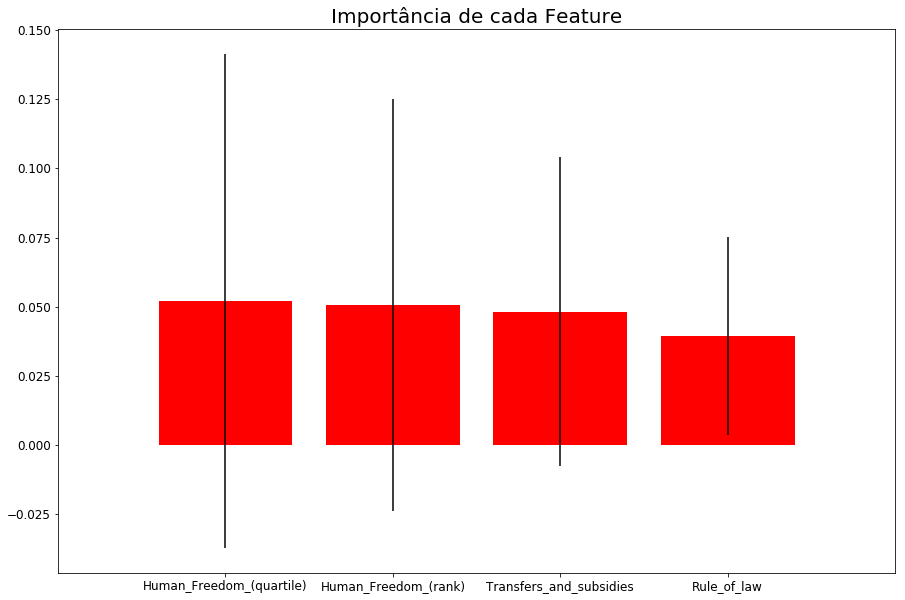

In [119]:
import scikitplot as skplt
skplt.estimators.plot_feature_importances(RFC,title="Importância de cada Feature",
                                          title_fontsize=20,
                                          text_fontsize=12,
                                          feature_names=data_feature_names,
                                          max_num_features=4,
                                          figsize=(15,10));

# Cross Validation com Múltiplos Classificadores

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

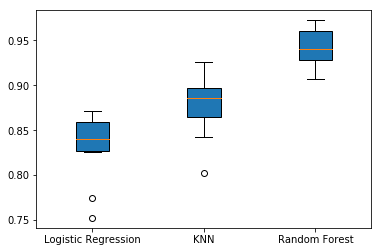

In [123]:
l=[]

classifiers = [LogisticRegression(solver='lbfgs',multi_class="multinomial",random_state=42,n_jobs=-1),
               KNeighborsClassifier(n_jobs=-1),
               RandomForestClassifier(n_estimators=100,verbose=0,n_jobs=-1)]

names = ["Logistic Regression","KNN","Random Forest"]

def train_and_test(clf, name):
    scores = cross_val_score(clf, x_train, y_train, cv=10)
    l.append(scores)

for name, clf in zip(names, classifiers):
    train_and_test(clf, name);


fig = plt.boxplot(l,patch_artist=True,labels=names);

* Utilizaremos o que tem melhores resultados que é o Random Forest Classifier

# Randomized Search com Hiper Parâmetros

In [61]:
from sklearn.model_selection import RandomizedSearchCV

In [62]:
hyper_param = {
    "n_estimators": [10,25,50,75,100],
    "criterion"  :["gini","entropy"],
    "max_depth"  :[40,50,60,70,80,90]
}

In [63]:
rsc = RandomizedSearchCV(RFC,hyper_param, verbose=1, random_state=42,n_jobs=-1,cv=10)

In [64]:
rsc.fit(x_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.3s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [10, 25, 50, 75, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [40, 50, 60, 70, 80, 90]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

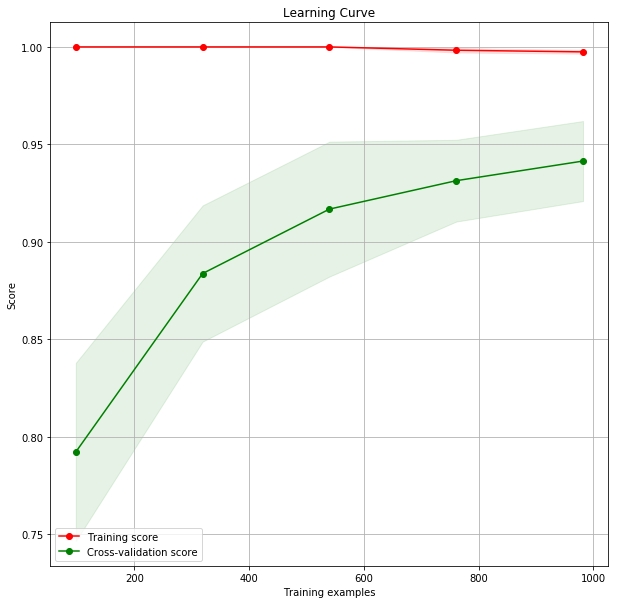

In [87]:
skplt.estimators.plot_learning_curve(rsc.best_estimator_,x_train,y_train,n_jobs=-1,cv=10,figsize=(10,10))

In [65]:
rfc_h_pred = rsc.predict(X_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.0s finished


In [66]:
rsc.best_score_

0.9414455626715462

In [67]:
rsc.best_params_

{'n_estimators': 75, 'max_depth': 70, 'criterion': 'entropy'}

# Matriz de Confusão

In [68]:
from sklearn.metrics import confusion_matrix


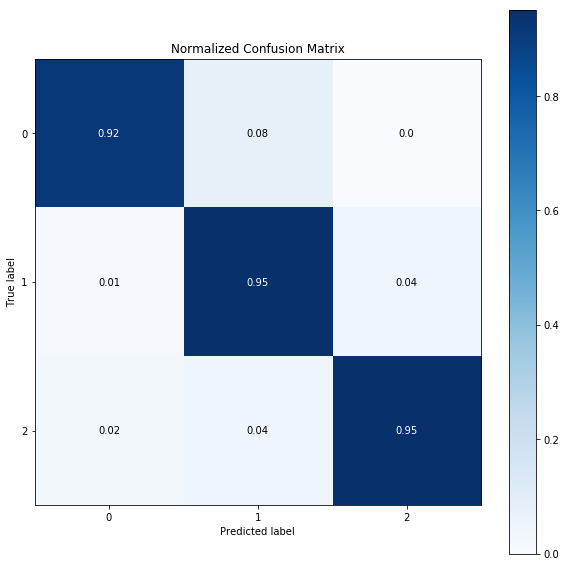

In [69]:
skplt.metrics.plot_confusion_matrix(Y_val,rfc_h_pred,normalize=True,figsize=(10,10))
#print(confusion_matrix(Y_val, rfc_h_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.0s finished


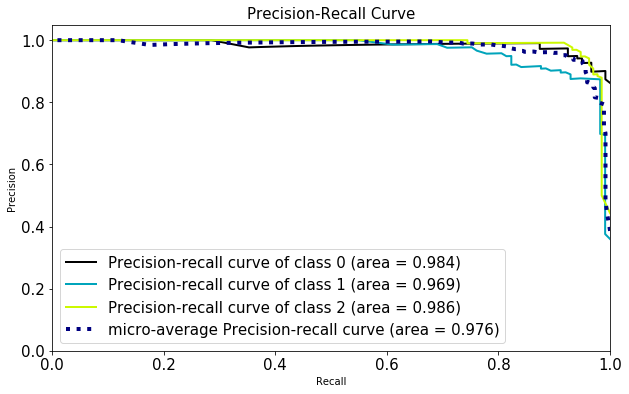

In [85]:
y_proba = rsc.predict_proba(X_val)
skplt.metrics.plot_precision_recall(Y_val,y_proba,title_fontsize=15,text_fontsize=15,figsize=(10,6))
plt.show()

# Precision/Recall

In [35]:
AxA, AxB, AxC, BxA, BxB, BxC, CxA, CxB, CxC = confusion_matrix(Y_val, rfc_h_pred).ravel()
print(AxA)
print(AxB)
print(AxC)
print(BxA)
print(BxB)
print(BxC)
print(CxA)
print(CxB)
print(CxC)

110
9
0
2
107
4
2
8
123


 # Recall

In [36]:
#axo q tá certo
tprA = AxA/(AxB + AxC + AxA)
tprA

0.9243697478991597

In [37]:
tprB = BxB/(BxA + BxB + BxC)
tprB

0.9469026548672567

In [38]:
tprC = CxC/(CxA + CxB + CxC)
tprC

0.924812030075188

#  Precision

In [39]:
precA = AxA/(AxA + BxA +CxA)
precA

0.9649122807017544

In [40]:
precB = BxB/(AxB + BxB + CxB)
precB

0.8629032258064516

In [41]:
precC = CxC/(AxC + BxC +CxC)
precC

0.968503937007874

In [37]:
(precA + precB + precC)/3

0.9476060841759572